In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import audioread
from pydub import AudioSegment
import soundfile as sf
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Data Preprocessing


 Loading metadata

In [2]:
sentence_df = pd.read_csv('./CREMA-D-master/SentenceFilenames.csv')
demographics_df = pd.read_csv('./CREMA-D-master/VideoDemographics.csv')
ratings_df = pd.read_csv('./CREMA-D-master/processedResults/tabulatedVotes.csv')


In [3]:
print("Sentence Data:\n", sentence_df.head())
print("\nDemographics:\n", demographics_df.head())
print("\nRatings:\n", ratings_df.head())

Sentence Data:
    Stimulus_Number         Filename
0                1  1001_IEO_NEU_XX
1                2  1001_IEO_HAP_LO
2                3  1001_IEO_HAP_MD
3                4  1001_IEO_HAP_HI
4                5  1001_IEO_SAD_LO

Demographics:
    ActorID  Age     Sex              Race     Ethnicity
0     1001   51    Male         Caucasian  Not Hispanic
1     1002   21  Female         Caucasian  Not Hispanic
2     1003   21  Female         Caucasian  Not Hispanic
3     1004   42  Female         Caucasian  Not Hispanic
4     1005   29    Male  African American  Not Hispanic

Ratings:
    Unnamed: 0  A  D  F  H   N  S         fileName  numResponses  agreement  \
0      100001  0  0  0  1  10  0  1001_IEO_NEU_XX            11   0.909091   
1      100002  0  0  0  3   6  0  1001_IEO_HAP_LO             9   0.666667   
2      100003  0  0  0  4   7  0  1001_IEO_HAP_MD            11   0.636364   
3      100004  2  0  0  6   2  0  1001_IEO_HAP_HI            10   0.600000   
4      100005  

Loading Audio files

In [4]:
import os

audio_folder = './CREMA-D-master/AudioWAV/'

audio_files = [f for f in os.listdir(audio_folder) if f.endswith(".wav")]
print(f"Total audio files found: {len(audio_files)}")


Total audio files found: 7443


In [45]:
# Paths
input_folder = './CREMA-D-master/Raw_audio/'
output_folder = './CREMA-D-master/Converted_wav/'
os.makedirs(output_folder, exist_ok=True)

# Convert all .mp3 files
for filename in os.listdir(input_folder):
    if filename.endswith('.mp3'):
        mp3_path = os.path.join(input_folder, filename)
        wav_name = os.path.splitext(filename)[0] + ".wav"
        wav_path = os.path.join(output_folder, wav_name)

        try:
            sound = AudioSegment.from_mp3(mp3_path)
            sound = sound.set_frame_rate(16000).set_channels(1)  # match CREMA-D format
            sound.export(wav_path, format="wav")
            print(f"Converted: {filename} -> {wav_name}")
        except Exception as e:
            print(f"Error converting {filename}: {e}")

Converted: 96.mp3 -> 96.wav
Converted: 69.mp3 -> 69.wav
Converted: 41.mp3 -> 41.wav
Converted: 55.mp3 -> 55.wav
Converted: 54.mp3 -> 54.wav
Converted: 6.mp3 -> 6.wav
Converted: 40.mp3 -> 40.wav
Converted: 68.mp3 -> 68.wav
Converted: 83.mp3 -> 83.wav
Converted: 95.mp3 -> 95.wav
Converted: 81.mp3 -> 81.wav
Converted: 56.mp3 -> 56.wav
Converted: 42.mp3 -> 42.wav
Converted: 43.mp3 -> 43.wav
Converted: 5.mp3 -> 5.wav
Converted: 57.mp3 -> 57.wav
Converted: 80.mp3 -> 80.wav
Converted: 94.mp3 -> 94.wav
Converted: 90.mp3 -> 90.wav
Converted: 84.mp3 -> 84.wav
Converted: 53.mp3 -> 53.wav
Converted: 1.mp3 -> 1.wav
Converted: 47.mp3 -> 47.wav
Converted: 46.mp3 -> 46.wav
Converted: 52.mp3 -> 52.wav
Converted: 91.mp3 -> 91.wav
Converted: 87.mp3 -> 87.wav
Converted: 93.mp3 -> 93.wav
Converted: 44.mp3 -> 44.wav
Converted: 2.mp3 -> 2.wav
Converted: 50.mp3 -> 50.wav
Converted: 78.mp3 -> 78.wav
Converted: 79.mp3 -> 79.wav
Converted: 51.mp3 -> 51.wav
Converted: 45.mp3 -> 45.wav
Converted: 92.mp3 -> 92.wav


In [47]:
crema_folder = './CREMA-D-master/AudioWAV/'
converted_folder = './CREMA-D-master/Converted_wav/'

# List all .wav files with full paths
crema_files = [os.path.join(crema_folder, f) for f in os.listdir(crema_folder) if f.endswith('.wav')]
converted_files = [os.path.join(converted_folder, f) for f in os.listdir(converted_folder) if f.endswith('.wav')]

# Combine them
all_audio_files = crema_files + converted_files
print(f"Total audio files: {len(all_audio_files)}")

Total audio files: 7548


In [49]:
from tqdm import tqdm
def extract_features(file_path):
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=16000)  # Resampling to 16kHz
        
        # MFCCs (Mel-Frequency Cepstral Coefficients)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfccs_mean = np.mean(mfccs, axis=1)

        # Pitch (Fundamental Frequency F0)
        f0, voiced_flag, _ = librosa.pyin(y, fmin=50, fmax=300)
        f0_mean = np.nanmean(f0) if np.any(~np.isnan(f0)) else 0

        # RMS Energy
        rms = librosa.feature.rms(y=y)
        rms_mean = np.mean(rms)

        # Zero-Crossing Rate (ZCR)
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = np.mean(zcr)

        return [file_path, *mfccs_mean, f0_mean, rms_mean, zcr_mean]

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Create an empty list to store features
features_list = []

for file_path in tqdm(all_audio_files):
    features = extract_features(file_path)
    if features:
        features_list.append(features)

# Define column names
columns = ["filename"] + [f"mfcc_{i}" for i in range(40)] + ["f0_mean", "rms_mean", "zcr_mean"]

# Convert to DataFrame
df_features = pd.DataFrame(features_list, columns=columns)

df_features.to_csv("audio_features.csv", index=False)
print("Feature extraction completed and saved to audio_features.csv!")


 30%|███████████▌                           | 2239/7548 [02:54<07:09, 12.36it/s]/Users/aroofapanjwani/Desktop/Spring_2025/Cmpt_419/AI-Based-Public-Speaking-Feedback-System/419venv/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
 30%|███████████▌                           | 2243/7548 [02:54<07:09, 12.36it/s]

Error processing ./CREMA-D-master/AudioWAV/1040_ITH_SAD_XX.wav: 


100%|███████████████████████████████████████| 7548/7548 [15:57<00:00,  7.88it/s]

Feature extraction completed and saved to audio_features.csv!


Compute clarity features:

In [50]:
df_features = pd.read_csv("./audio_features.csv")
df_features.head()

,filename,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,mfcc_33,mfcc_34,mfcc_35,mfcc_36,mfcc_37,mfcc_38,mfcc_39,f0_mean,rms_mean,zcr_mean
0,./CREMA-D-master/AudioWAV/1022_ITS_ANG_XX.wav,-236.38174,83.463480,16.295732,33.203766,-6.664413,-14.425650,-4.911797,-11.599966,-3.067404,...,3.061785,5.327828,1.842284,0.104547,-0.843781,2.916789,4.632835,233.376426,0.098989,0.125387
1,./CREMA-D-master/AudioWAV/1037_ITS_ANG_XX.wav,-309.69480,98.229660,34.212830,22.234697,-5.294956,-6.240134,-4.689807,-4.643988,-5.195683,...,-0.290050,-0.540923,-2.028972,-0.156424,2.250125,3.064375,1.814954,219.192942,0.040105,0.120117
2,./CREMA-D-master/AudioWAV/1060_ITS_NEU_XX.wav,-381.40660,103.938866,35.128147,23.225817,9.317840,1.143645,3.261375,-4.931952,1.491559,...,5.467684,4.260236,2.512686,1.135265,-0.903156,-0.852135,-1.304143,259.955186,0.009055,0.078144
3,./CREMA-D-master/AudioWAV/1075_ITS_NEU_XX.wav,-374.81824,108.603020,42.597740,26.419222,1.243140,-4.584768,4.113737,-0.431038,-0.400238,...,3.429506,2.834391,0.924989,0.795283,0.179894,-1.028957,-0.280594,228.302382,0.011636,0.080224
4,./CREMA-D-master/AudioWAV/1073_IOM_DIS_XX.wav,-382.00946,109.520680,38.729843,38.809590,5.929746,2.809155,2.577616,-8.267661,1.585591,...,5.726671,3.134196,2.060298,-0.146954,-1.763854,1.184271,2.224355,240.262457,0.015059,0.054693


In [51]:
def calculate_mfcc_variance(df):
    mfcc_columns = [f"mfcc_{i}" for i in range(40)]
    df['mfcc_variance'] = df[mfcc_columns].var(axis=1)
    return df

def calculate_spectral_centroid(file_path):
    try:
        y, sr = librosa.load(file_path, sr=16000)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        return np.mean(spectral_centroid)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.nan

# Add Spectral Centroid to the DataFrame
df_features['spectral_centroid'] = df_features['filename'].apply(calculate_spectral_centroid)


# Let's assume it's proportional to the RMS energy variation.
def calculate_articulation_rate(file_path):
    try:
        y, sr = librosa.load(file_path, sr=16000)
        rms = librosa.feature.rms(y=y)
        articulation_rate = np.mean(rms)  # Simplified as RMS mean
        return articulation_rate
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.nan

# Add Articulation Rate to the DataFrame
df_features['articulation_rate'] = df_features['filename'].apply(calculate_articulation_rate)

# Calculate MFCC Variance
df_features = calculate_mfcc_variance(df_features)

# Display updated DataFrame with clarity features
df_features.head()


,filename,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,mfcc_36,mfcc_37,mfcc_38,mfcc_39,f0_mean,rms_mean,zcr_mean,spectral_centroid,articulation_rate,mfcc_variance
0,./CREMA-D-master/AudioWAV/1022_ITS_ANG_XX.wav,-236.38174,83.463480,16.295732,33.203766,-6.664413,-14.425650,-4.911797,-11.599966,-3.067404,...,0.104547,-0.843781,2.916789,4.632835,233.376426,0.098989,0.125387,1822.566123,0.098989,1650.931944
1,./CREMA-D-master/AudioWAV/1037_ITS_ANG_XX.wav,-309.69480,98.229660,34.212830,22.234697,-5.294956,-6.240134,-4.689807,-4.643988,-5.195683,...,-0.156424,2.250125,3.064375,1.814954,219.192942,0.040105,0.120117,1695.907043,0.040105,2734.923164
2,./CREMA-D-master/AudioWAV/1060_ITS_NEU_XX.wav,-381.40660,103.938866,35.128147,23.225817,9.317840,1.143645,3.261375,-4.931952,1.491559,...,1.135265,-0.903156,-0.852135,-1.304143,259.955186,0.009055,0.078144,1482.563695,0.009055,4026.090613
3,./CREMA-D-master/AudioWAV/1075_ITS_NEU_XX.wav,-374.81824,108.603020,42.597740,26.419222,1.243140,-4.584768,4.113737,-0.431038,-0.400238,...,0.795283,0.179894,-1.028957,-0.280594,228.302382,0.011636,0.080224,1438.130000,0.011636,3946.259452
4,./CREMA-D-master/AudioWAV/1073_IOM_DIS_XX.wav,-382.00946,109.520680,38.729843,38.809590,5.929746,2.809155,2.577616,-8.267661,1.585591,...,-0.146954,-1.763854,1.184271,2.224355,240.262457,0.015059,0.054693,1238.812481,0.015059,4107.010625


Data Cleaning

filename    0
mfcc_0      0
mfcc_1      0
mfcc_2      0
mfcc_3      0
mfcc_4      0
mfcc_5      0
mfcc_6      0
mfcc_7      0
mfcc_8      0
mfcc_9      0
mfcc_10     0
mfcc_11     0
mfcc_12     0
mfcc_13     0
mfcc_14     0
mfcc_15     0
mfcc_16     0
mfcc_17     0
mfcc_18     0
mfcc_19     0
mfcc_20     0
mfcc_21     0
mfcc_22     0
mfcc_23     0
mfcc_24     0
mfcc_25     0
mfcc_26     0
mfcc_27     0
mfcc_28     0
mfcc_29     0
mfcc_30     0
mfcc_31     0
mfcc_32     0
mfcc_33     0
mfcc_34     0
mfcc_35     0
mfcc_36     0
mfcc_37     0
mfcc_38     0
mfcc_39     0
f0_mean     0
rms_mean    0
zcr_mean    0
dtype: int64
            mfcc_0       mfcc_1       mfcc_2       mfcc_3       mfcc_4  \
count  7547.000000  7547.000000  7547.000000  7547.000000  7547.000000   
mean   -353.508925   101.677031    32.126915    22.794948     5.582863   
std      58.111044    14.477115    14.391690     7.404679     8.572242   
min   -1131.371000     0.000000   -21.610441    -8.914308   -32.680992   
2

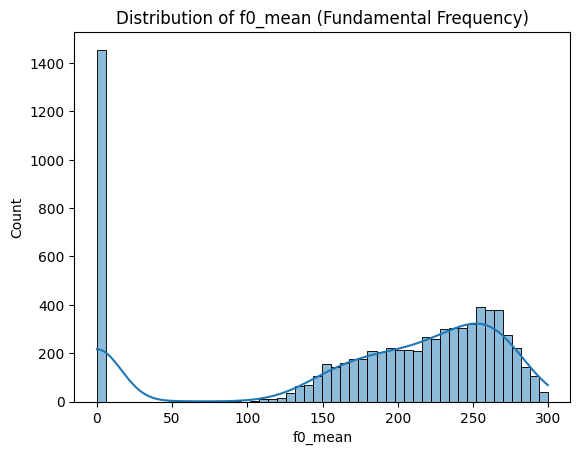

In [52]:
df = pd.read_csv("./audio_features.csv")

# Check for missing values
print(df.isnull().sum())

# Summary statistics
print(df.describe())

# Check correlations
df_numeric = df.drop(columns=['filename'])  # Remove filename column
correlation_matrix = df_numeric.corr()  # Compute correlation matrix
print(correlation_matrix)

# Visualizing feature distributions

sns.histplot(df['f0_mean'], bins=50, kde=True)
plt.title("Distribution of f0_mean (Fundamental Frequency)")
plt.show()


In [9]:
# Drop filename for numerical analysis
df_numeric = df.drop(columns=['filename'])

# Identify rows with zero pitch or energy
zero_pitch = df_numeric[df_numeric['f0_mean'] == 0]
zero_energy = df_numeric[df_numeric['rms_mean'] == 0]

print(f"Zero Pitch Count: {len(zero_pitch)}")
print(f"Zero Energy Count: {len(zero_energy)}")

# Detect outliers using IQR
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

outliers = ((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).sum()
print("\nOutlier Count per Feature:")
print(outliers)


Zero Pitch Count: 1455
Zero Energy Count: 1

Outlier Count per Feature:
mfcc_0       137
mfcc_1       239
mfcc_2        76
mfcc_3        87
mfcc_4       136
mfcc_5        69
mfcc_6        97
mfcc_7        71
mfcc_8       148
mfcc_9       222
mfcc_10      106
mfcc_11      403
mfcc_12      147
mfcc_13      135
mfcc_14      275
mfcc_15      203
mfcc_16      150
mfcc_17      206
mfcc_18      238
mfcc_19      223
mfcc_20      261
mfcc_21      422
mfcc_22      207
mfcc_23      263
mfcc_24      237
mfcc_25      218
mfcc_26      219
mfcc_27      221
mfcc_28      172
mfcc_29      139
mfcc_30      183
mfcc_31      210
mfcc_32      174
mfcc_33      132
mfcc_34      154
mfcc_35      147
mfcc_36       94
mfcc_37      132
mfcc_38      157
mfcc_39      116
f0_mean     1455
rms_mean     710
zcr_mean     432
dtype: int64


In [53]:
# Replace zero values in 'f0_mean' with the minimum non-zero pitch
min_f0 = df[df['f0_mean'] > 0]['f0_mean'].min()
df['f0_mean'] = df['f0_mean'].replace(0, min_f0)

# Alternatively, replace zero values in 'rms_mean' with the minimum non-zero RMS value
min_rms = df[df['rms_mean'] > 0]['rms_mean'].min()
df['rms_mean'] = df['rms_mean'].replace(0, min_rms)

# Define a function to filter out outliers based on IQR
def filter_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df
#df_filtered = filter_outliers(df, df.columns[1:])

def cap_outliers(df, cols, lower_percentile=0.15, upper_percentile=0.85):
    for col in cols:
        lower_bound = df[col].quantile(lower_percentile)
        upper_bound = df[col].quantile(upper_percentile)
        df[col] = np.clip(df[col], lower_bound, upper_bound)
    return df

# Apply filtering on MFCCs and other features with potential outliers
df_filtered = cap_outliers(df, df.columns[1:])  # Filtering all feature columns (excluding 'filename')


Original dataset shape: (7442, 50)
Filtered dataset shape: (7442, 50)


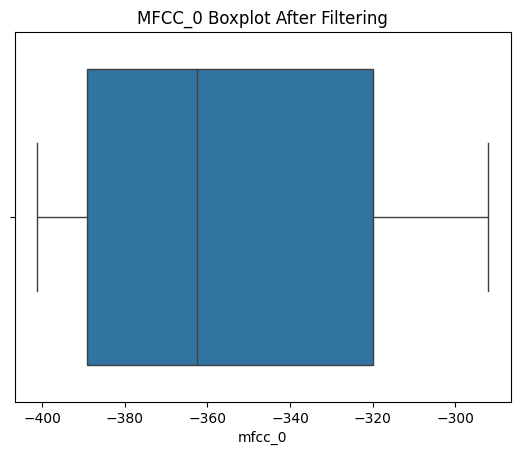

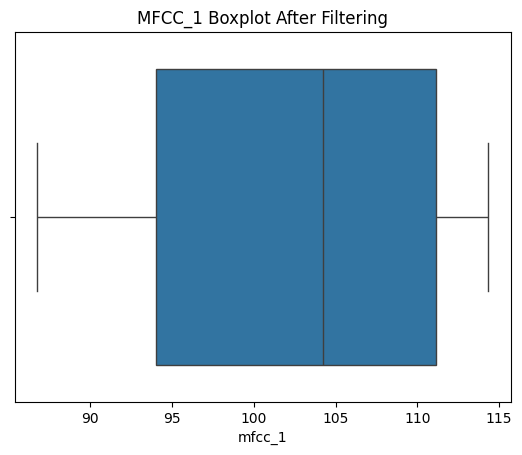

In [32]:
# Before filtering
print(f"Original dataset shape: {df.shape}")

# After filtering
print(f"Filtered dataset shape: {df_filtered.shape}")
sns.boxplot(x=df_filtered['mfcc_0'])
plt.title('MFCC_0 Boxplot After Filtering')
plt.show()

# Repeat for other features if needed
sns.boxplot(x=df_filtered['mfcc_1'])
plt.title('MFCC_1 Boxplot After Filtering')
plt.show()

Confidence features

In [54]:
# Calculate pitch variation (standard deviation of F0)
df_filtered['pitch_variation'] = df_filtered['f0_mean'].std()

# Calculate energy stability (standard deviation of RMS energy)
df_filtered['energy_stability'] = df_filtered['rms_mean'].std()


Fluency features

In [55]:
# Define a threshold for detecting pauses (e.g., RMS <= 0.01 is a pause)
pause_threshold = 0.01
df_filtered['pause_frequency'] = (df_filtered['rms_mean'] <= pause_threshold).sum()

# Calculate pause duration as the number of consecutive RMS values below the threshold
df_filtered['pause_duration'] = df_filtered['rms_mean'][df_filtered['rms_mean'] <= pause_threshold].count()

# Calculate speaking rate as the number of non-zero RMS values
df_filtered['speaking_rate'] = (df_filtered['rms_mean'] > pause_threshold).sum()


In [56]:
# print(df_filtered[['filename', 'mfcc_variance', 'spectral_centroid', 'articulation_rate', 'pitch_variation', 'energy_stability', 'pause_frequency', 'pause_duration', 'speaking_rate' ]].head())

cols_to_add = ['filename', 'articulation_rate', 'mfcc_variance', 'spectral_centroid']
df_selected = df_features[cols_to_add]
df_final = pd.merge(df_filtered, df_selected, on='filename', how='left')

# Drop mfcc from df_final
mfcc_columns = [f"mfcc_{i}" for i in range(40)]
df_final = df_final.drop(columns=mfcc_columns)
print(df_final.columns)

# print(df_final[['filename', 'mfcc_variance', 'spectral_centroid', 'articulation_rate', 'pitch_variation', 'energy_stability', 'pause_frequency', 'pause_duration', 'speaking_rate' ]].head())
print(df_final.head())

Index(['filename', 'f0_mean', 'rms_mean', 'zcr_mean', 'pitch_variation',
       'energy_stability', 'pause_frequency', 'pause_duration',
       'speaking_rate', 'articulation_rate', 'mfcc_variance',
       'spectral_centroid'],
      dtype='object')
                                        filename     f0_mean  rms_mean  \
0  ./CREMA-D-master/AudioWAV/1022_ITS_ANG_XX.wav  233.376426  0.047915   
1  ./CREMA-D-master/AudioWAV/1037_ITS_ANG_XX.wav  219.192942  0.040105   
2  ./CREMA-D-master/AudioWAV/1060_ITS_NEU_XX.wav  259.955186  0.009076   
3  ./CREMA-D-master/AudioWAV/1075_ITS_NEU_XX.wav  228.302382  0.011636   
4  ./CREMA-D-master/AudioWAV/1073_IOM_DIS_XX.wav  240.262457  0.015059   

   zcr_mean  pitch_variation  energy_stability  pause_frequency  \
0  0.109725         76.14376          0.013973             1520   
1  0.109725         76.14376          0.013973             1520   
2  0.078144         76.14376          0.013973             1520   
3  0.080224         76.14376         

# Data Training #

PCA to reduce dimensionality

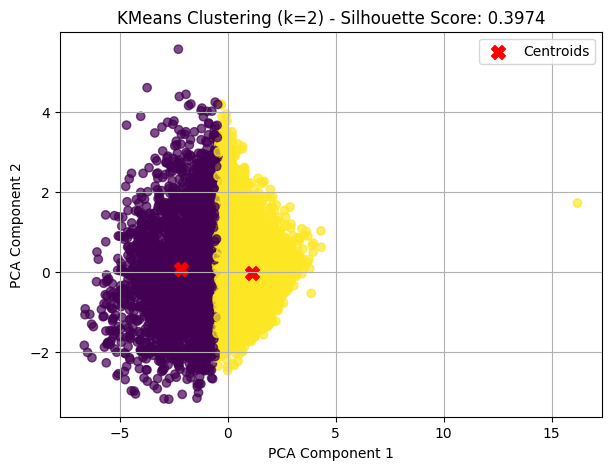

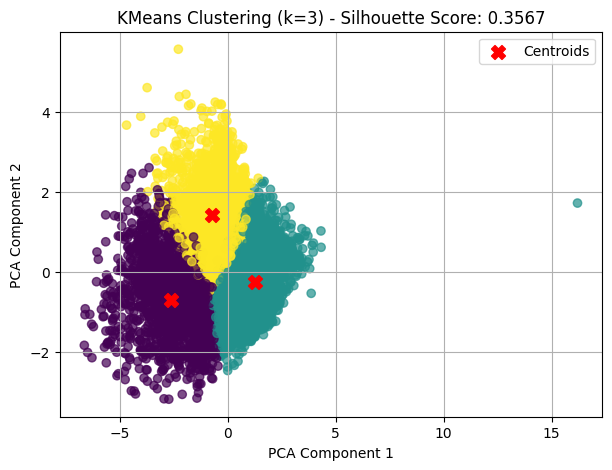

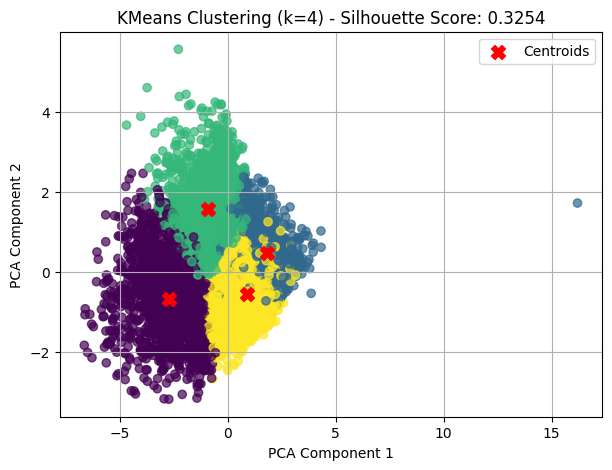

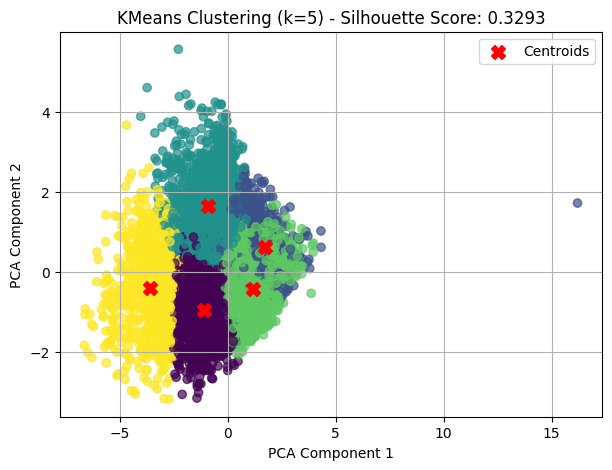

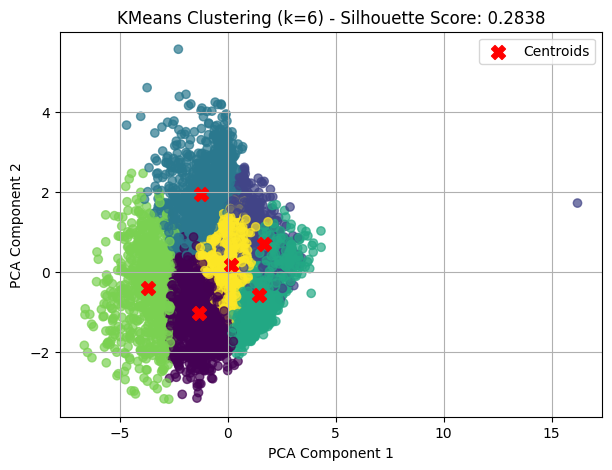

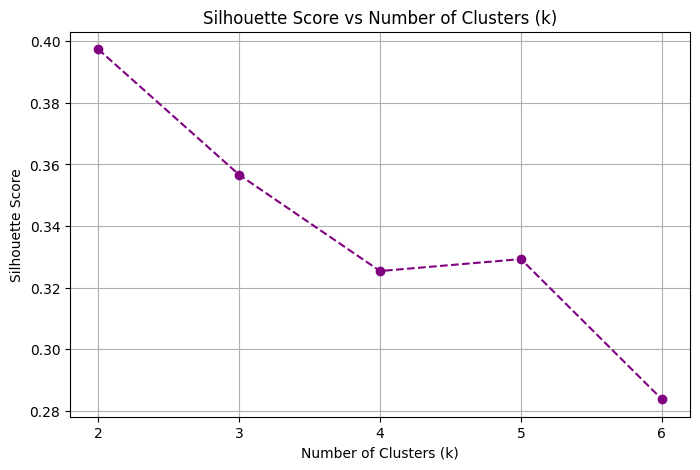

In [61]:
from sklearn.metrics import silhouette_score
# Features for clustering
columns_for_clustering = [
    'f0_mean', 'rms_mean', 'zcr_mean', 'pitch_variation', 'energy_stability',
    'pause_frequency', 'pause_duration', 'speaking_rate',
    'articulation_rate', 'mfcc_variance', 'spectral_centroid'
]

# 1. Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_final[columns_for_clustering])
joblib.dump(scaler, "scaler.pkl")

# 2. Try different k values
k_values = range(2, 7)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    
    score = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(score)
    
    # PCA for visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(scaled_data)
    centroids_2d = pca.transform(kmeans.cluster_centers_)
    
    # Plot clusters
    plt.figure(figsize=(7, 5))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='red', marker='X', s=100, label='Centroids')
    plt.title(f'KMeans Clustering (k={k}) - Silhouette Score: {score:.4f}')
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# 3. Plot silhouette score summary
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='purple')
plt.title("Silhouette Score vs Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.xticks(k_values)
plt.show()

In [62]:
kmeans = KMeans(n_clusters=3, random_state=42)

# classify the three clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df_final['cluster'] = kmeans.fit_predict(df_final[columns_for_clustering])

# Analyze the clusters
cluster_summary = df_final.groupby('cluster')[columns_for_clustering].mean().round(2)

print("Cluster Feature Averages:")
print(cluster_summary)

Cluster Feature Averages:
         f0_mean  rms_mean  zcr_mean  pitch_variation  energy_stability  \
cluster                                                                   
0         210.78      0.04      0.10            76.14              0.01   
1         161.36      0.01      0.07            76.14              0.01   
2         189.16      0.02      0.08            76.14              0.01   

         pause_frequency  pause_duration  speaking_rate  articulation_rate  \
cluster                                                                      
0                 1520.0          1520.0         6027.0               0.06   
1                 1520.0          1520.0         6027.0               0.01   
2                 1520.0          1520.0         6027.0               0.02   

         mfcc_variance  spectral_centroid  
cluster                                    
0              2248.82            1667.89  
1              4829.59            1319.37  
2              3689.84         

In [64]:
cluster_labels = {
    0: "Fluent",
    1: "Unclear",
    2: "Moderate"
}

df_final["label"] = df_final["cluster"].map(cluster_labels)

Cluster 0:
High pitch, energy, articulation rate, spectral centroid
→ Fluent

Cluster 1:
Low pitch, low energy, very low articulation, highest MFCC variance
→ Unclear (likely underconfident or anxious speech)

Cluster 2:
Average across the board
→ Moderate

Train-test split

In [65]:
features = [
    'f0_mean', 'rms_mean', 'zcr_mean', 'pitch_variation', 'energy_stability',
    'pause_frequency', 'pause_duration', 'speaking_rate',
    'articulation_rate', 'mfcc_variance', 'spectral_centroid'
]

X = df_final[features]
y = df_final['cluster']  # Cluster labels (Fluent, Hesitant, Moderate → 0, 1, 2)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Train size: 6037, Test size: 1510


In [66]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

# Fit model on updated features and cluster labels
grid_search.fit(X_train, y_train)

# Best model after tuning
best_model = grid_search.best_estimator_

# Save the trained model for testing
joblib.dump(best_model, 'fluency_classifier.pkl')
print("Model training complete and saved to 'fluency_classifier.pkl'")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Model training complete and saved to 'fluency_classifier.pkl'


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
               precision    recall  f1-score   support

      Fluent       0.99      0.99      0.99       398
    Hesitant       0.99      0.99      0.99       367
    Moderate       0.99      0.99      0.99       745

    accuracy                           0.99      1510
   macro avg       0.99      0.99      0.99      1510
weighted avg       0.99      0.99      0.99      1510



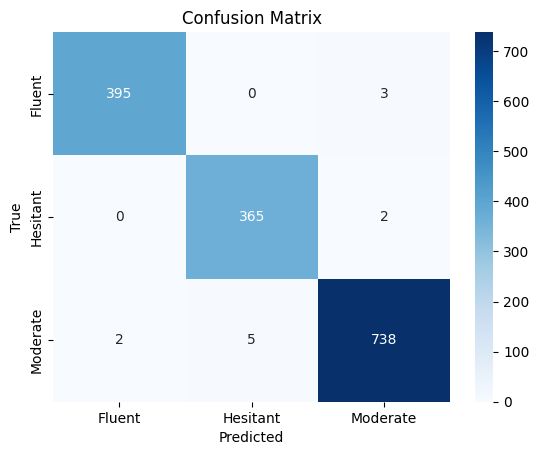

In [68]:
# Predict on test set
y_pred = best_model.predict(X_test)

# Label mapping (adjust if needed)
label_mapping = {
    0: "Fluent",
    1: "Unclear",
    2: "Moderate"
}

# Convert to readable labels
y_test_named = y_test.map(label_mapping)
y_pred_named = pd.Series(y_pred).map(label_mapping)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Classification report with readable labels
print("\nClassification Report:\n", classification_report(y_test_named, y_pred_named))

# Confusion Matrix
labels = list(label_mapping.values())
cm = confusion_matrix(y_test_named, y_pred_named, labels=labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Feature extraction for a single audio file

In [77]:
def generate_feedback(cluster_label):
    cluster_label = int(cluster_label)  # Ensure it's a plain Python int

    label_dict = {
        0: "Fluent",
        1: "Unclear",
        2: "Moderate"
    }

    feedback_dict = {
        0: "Great job! Your speech is fluent and confident.",
        1: "You sound hesitant. Try reducing pauses and increasing vocal energy.",
        2: "Your speech is moderate. Try increasing clarity and adding more vocal variation."
    }

    label = label_dict.get(cluster_label, "Unknown")
    feedback = feedback_dict.get(cluster_label, "Unable to generate feedback.")
    return label, feedback  

In [78]:
def predict_and_feedback(file_path):
    features = extract_features(file_path)

    if features:
        # Extract only the last 11 features from the output
        # (drop filename + mfccs)
        feature_values = features[-11:]  # Only keep the trained features

        # Feature columns used during model training
        columns = [
            'f0_mean', 'rms_mean', 'zcr_mean', 'pitch_variation', 'energy_stability',
            'pause_frequency', 'pause_duration', 'speaking_rate',
            'articulation_rate', 'mfcc_variance', 'spectral_centroid'
        ]

        # Create a DataFrame with correct shape and column names
        input_df = pd.DataFrame([feature_values], columns=columns)

        # Load scaler and model
        scaler = joblib.load("scaler.pkl")
        model = joblib.load("fluency_classifier.pkl")

        # Standardize input features
        input_scaled = scaler.transform(input_df)

#         # Predict cluster
#         predicted_label = model.predict(input_scaled)[0]

#         # Generate feedback
#         feedback = generate_feedback(predicted_label)

#         print(f"Predicted Cluster: {predicted_label}")
#         print(f"Feedback: {feedback}")
#         return predicted_label, feedback

#     else:
#         print("Feature extraction failed.")
#         return None, None

        # Predict cluster
        predicted_label = model.predict(input_scaled)[0]

        # DEBUG LINE — print the label and its type
#         print("DEBUG: Raw predicted_label =", predicted_label, type(predicted_label))

        # Generate feedback
        label, feedback = generate_feedback(predicted_label)

        print(f"Predicted Cluster: {predicted_label} ({label})")
        print(f"Feedback: {feedback}")


In [79]:
predict_and_feedback("./Test_audio/Bad_Public_Speaking_4.wav")

predict_and_feedback("./CREMA-D-master/Raw_audio/2")

/Users/aroofapanjwani/Desktop/Spring_2025/Cmpt_419/AI-Based-Public-Speaking-Feedback-System/CREMA-D-master/Raw_audio

Predicted Cluster: 0 (Fluent)
Feedback: Great job! Your speech is fluent and confident.


/Users/aroofapanjwani/Desktop/Spring_2025/Cmpt_419/AI-Based-Public-Speaking-Feedback-System/419venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
